## 1. Import necessary libraries

In [1]:
# Data representation and computation
import pandas as pd  
import numpy as np  
pd.options.display.float_format = '{:20,.4f}'.format

# Graph plotting
import matplotlib.pyplot as plt  
import seaborn as sns

# Data splitting, feature engg., and pipeline to train machine learning models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import cluster, silhouette_score, v_measure_score, adjusted_rand_score, completeness_score

# Machine learning models
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Miscellaneous
import warnings
from math import log, e, ceil
from scipy.stats import entropy
from prettytable import PrettyTable

# Declaration
warnings.filterwarnings('ignore')
%precision 2
%matplotlib inline
sns.set(font_scale=1)

<br><hr/>

## 2. Load Data

In [2]:
ldf_insulin_data = pd.read_csv("../input/meal-data-clustering/InsulinData.csv", 
                               encoding='latin', index_col=False)

ldf_insulin_data.head()

,Index,Date,Time,New Device Time,BG Reading (mg/dL),Linked BG Meter ID,Basal Rate (U/h),Temp Basal Amount,Temp Basal Type,Temp Basal Duration (h:mm:ss),...,Scroll Step Size,Insulin Action Curve Time,Sensor Calibration Rejected Reason,Preset Bolus,Bolus Source,Network Device Associated Reason,Network Device Disassociated Reason,Network Device Disconnected Reason,Sensor Exception,Preset Temp Basal Name
0,0,2/12/2018,13:20:53,NaN,nan,nan,nan,nan,nan,nan,...,NaN,nan,NaN,nan,NaN,TEMPORARY,NaN,NaN,nan,nan
1,1,2/12/2018,13:20:48,NaN,nan,nan,nan,nan,nan,nan,...,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,nan,nan
2,2,2/12/2018,13:18:48,NaN,nan,nan,0.0000,nan,nan,nan,...,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,nan,nan
3,3,2/12/2018,13:18:48,NaN,nan,nan,nan,nan,nan,nan,...,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,nan,nan
4,4,2/12/2018,13:12:33,NaN,nan,nan,nan,nan,nan,nan,...,NaN,nan,NaN,nan,CLOSED_LOOP_MICRO_BOLUS,NaN,NaN,NaN,nan,nan


<br><hr/>

## 3. Data Preprocessing

#### 3.1 Get necessary columns

In [3]:
ldf_insulin_data = ldf_insulin_data[["Date","Time","BWZ Carb Input (grams)"]]

#### 3.2 Drop null values

In [4]:
print("Original Data:",ldf_insulin_data.shape)

# Drop the null values
ldf_insulin_data = ldf_insulin_data.dropna()

print("After dropping null values:",ldf_insulin_data.shape)

Original Data: (41435, 3)
After dropping null values: (1040, 3)


#### 3.3 Feature Scaling
It’s an important data preprocessing step for most distance-based machine learning algorithms because it can have a significant impact on the performance of algorithm.

In [5]:
scaler = StandardScaler()
ldf_insulin_data["BWZ Carb Input (Scaled)"] = scaler.fit_transform(ldf_insulin_data['BWZ Carb Input (grams)'].values.reshape(-1, 1))

<br><hr/>

## 4. Statistical Summary

In [6]:
print("Number of records: "+str(len(ldf_insulin_data)))

Number of records: 1040


In [7]:
ldf_insulin_data.describe()

,BWZ Carb Input (grams),BWZ Carb Input (Scaled)
count,"1,040.0000","1,040.0000"
mean,27.8183,0.0000
std,27.1294,1.0005
min,0.0000,-1.0259
25%,0.0000,-1.0259
50%,21.0000,-0.2514
75%,45.0000,0.6336
max,129.0000,3.7314


In [8]:
ldf_insulin_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1040 entries, 48 to 41401
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     1040 non-null   object 
 1   Time                     1040 non-null   object 
 2   BWZ Carb Input (grams)   1040 non-null   float64
 3   BWZ Carb Input (Scaled)  1040 non-null   float64
dtypes: float64(2), object(2)
memory usage: 40.6+ KB


<br><hr/>

## 5. Extracting Ground Truth

> 1. Derive the max and min value of meal intake amount from the Y column of the Insulin data. <br/>
> 2. Discretize the meal amount in bins of size 20. <br/>
> 3. According to their meal amount put them in the respective bins. <br/>
> 4. Summary. <br/>

In total you should have N = max-min/20  bins.

#### 5.1 Derive the max and min value of meal intake amount from the Y - BWZ Carb Input (grams) column of the Insulin data.

In [9]:
max_meal_amount = max(ldf_insulin_data['BWZ Carb Input (grams)'])
min_meal_amount = min(ldf_insulin_data['BWZ Carb Input (grams)'])

print("Max value of meal intake amount (grams):", max_meal_amount)
print("Min value of meal intake amount (grams):", min_meal_amount)

Max value of meal intake amount (grams): 129.0
Min value of meal intake amount (grams): 0.0


In [10]:
number_of_bins = ceil((max_meal_amount-min_meal_amount)/20)
print("In total you should have N = (",max_meal_amount,"-",min_meal_amount,"/ 20) i.e.", number_of_bins, "bins")

In total you should have N = ( 129.0 - 0.0 / 20) i.e. 7 bins


#### 5.2 Discretize the meal amount in bins of size 20.

In [11]:
# Define bins
ldict_bins = {
    1:[0,20],
    2:[21,40],
    3:[41,60],
    4:[61,80],
    5:[81,100],
    6:[101,120],
    7:[121,140]
}

In [12]:
def get_bin(meal_amount_in_grams):
    """
    This method is used to get appropriate bin bucket 
    using the bin dictionary defined above.
    """
    lint_bin = 0
    for bin_number, bin_range in ldict_bins.items():
        if bin_range[0]<=meal_amount_in_grams<=bin_range[1]:
            lint_bin = bin_number
    return lint_bin

#### 5.3 According to their meal amount put them in the respective bins.

In [13]:
ldf_insulin_data['Ground Truth'] = ldf_insulin_data['BWZ Carb Input (grams)'].apply(lambda x: get_bin(x))

#### 5.4 Summary

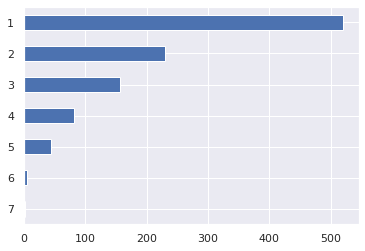

In [14]:
ldf_insulin_data["Ground Truth"].value_counts().sort_values(ascending=True).plot(kind="barh")

In [15]:
ldf_insulin_data.head()

,Date,Time,BWZ Carb Input (grams),BWZ Carb Input (Scaled),Ground Truth
48,2/12/2018,9:15:45,34.0000,0.2280,2
129,2/12/2018,2:30:55,15.0000,-0.4727,1
149,2/12/2018,0:15:41,0.0000,-1.0259,1
188,2/11/2018,20:33:18,71.0000,1.5925,4
202,2/11/2018,19:32:19,0.0000,-1.0259,1


In [16]:
ldf_insulin_data['Ground Truth'].values[:5]

array([2, 1, 1, 4, 1])

<br><hr/>

## 6. Perform clustering

> 1. Feature Selection. <br/>
> 2. Methods to calculate accuracy based on SSE, entropy and purity metrics
> 2. KMeans Clustering. <br/>
> 3. DBSCAN Clustering. <br/>
> 4. Accuracy report

#### 6.1 Feature Selection

In [17]:
X = ldf_insulin_data["BWZ Carb Input (Scaled)"].values.reshape(-1,1)

#### 6.2 Methods to calculate accuracy based on SSE, entropy and purity metrics

In [18]:
def calculate_entropy(y_true, y_pred, base = 2):
    """
    """
    contingency_matrix = cluster.contingency_matrix(y_true, y_pred)
    base = e if base is None else base
    
    Entropy = []

    for i in range(0, len(contingency_matrix)):
        p = contingency_matrix[i,:]
        p = pd.Series(p).value_counts(normalize=True, sort=False)
        Entropy.append((-p/p.sum() * np.log(p/p.sum())/np.log(2)).sum())
    
    TotalP = sum(contingency_matrix,1);
    WholeEntropy = 0;

    for i in range(0, len(contingency_matrix)):
        p = contingency_matrix[i,:]
        WholeEntropy = WholeEntropy + ((sum(p))/(sum(TotalP)))*Entropy[i]
    
    return WholeEntropy

In [19]:
def calculate_purity_score(y_true, y_pred):
    """
    Purity is an external evaluation criterion of cluster quality. 
    It is the percent of the total number of objects(data points) that were classified correctly.
    """
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = cluster.contingency_matrix(y_true, y_pred)

    Purity = []

    for i in range(0, len(contingency_matrix)):
        p = contingency_matrix[i,:]
        Purity.append(p.max()/p.sum())

    TotalP = sum(contingency_matrix,1);
    WholePurity = 0;

    for i in range(0, len(contingency_matrix)):
        p = contingency_matrix[i,:]
        WholePurity = WholePurity + ((sum(p))/(sum(TotalP)))*Purity[i]
    
    return WholePurity

In [20]:
def calculate_v_measure_score(y_true, y_pred):
    """
    This metric is independent of the absolute values of the labels: 
    a permutation of the class or cluster label values won’t change the score value in any way.
    """
    return v_measure_score(y_true, y_pred)

<hr/>

#### 6.3 KMeans Clustering<br/>
K-Means cluster is one of the most commonly used unsupervised machine learning clustering techniques. It is a centroid based clustering technique that needs you decide the number of clusters (centroids) and randomly places the cluster centroids to begin the clustering process. The goal is to divide N observations into K clusters repeatedly until no more groups can be formed.

##### Advantages of K-Means
1. Easy to understand and implement.
2. Can handle large datasets well.

##### Disadvantages of K-Means
1. Sensitive to number of clusters/centroids chosen. Even after using techniques like Elbow method, it is sometimes hard to generate good clusters.
2. Does not work well with outliers. Centroids can get dragged by the outliers resulting in skewed clusters.
3. Gets difficult in high dimensional spaces as the distance between the points increases and Euclidean distance diverges (converges to a constant value).
4. Gets slow as the number of dimensions increases.

In [21]:
# Define a model
kmeans = KMeans(n_clusters=7, random_state=42, max_iter=100)

# Fit a model
kmeans_model = kmeans.fit(X)

In [22]:
# The SSE value
print("The SSE value:\n"+ str(kmeans.inertia_))

# The number of iterations required to converge
print("\nThe number of iterations required to converge:\n"+str(kmeans.n_iter_))

# Compute the silhouette scores
kmeans_silhouette = silhouette_score(
    X, kmeans.labels_
).round(2)

print("\nSilhouette Score (A higher silhouette coefficient suggests better clusters):\n"+str(kmeans_silhouette))

The SSE value:
22.112587520020924

The number of iterations required to converge:
9

Silhouette Score (A higher silhouette coefficient suggests better clusters):
0.68


In [23]:
kmeans.labels_[:5]

array([2, 1, 6, 5, 6], dtype=int32)

Note that the order of the cluster labels are flipped. The order was [2, 1, 1, 4, 1] in true_labels but [2, 1, 6, 5, 6] in kmeans.labels_ even though those data objects are still members of their original clusters in kmeans.lables_.

This behavior is normal, as the ordering of cluster labels is dependent on the initialization. Cluster 0 from the first run could be labeled cluster 1 in the second run and vice versa. This doesn’t affect clustering evaluation metrics.

In [24]:
# Create a column of K-means Prediction
ldf_insulin_data['KmeanCluster'] = kmeans_model.predict(X)

In [25]:
# Calculate accuracy using entropy, purity_score, & v-measure score
kmean_entropy = calculate_entropy(ldf_insulin_data['Ground Truth'],ldf_insulin_data['KmeanCluster'])
kmean_purity_score = calculate_purity_score(ldf_insulin_data['Ground Truth'],ldf_insulin_data['KmeanCluster'])
kmean_v_measure_score = calculate_v_measure_score(ldf_insulin_data['Ground Truth'], ldf_insulin_data['KmeanCluster'])

<hr/>

#### 6.4 DBSCAN Clustering<br/>
DBSCAN is a density-based clustering algorithm that forms clusters of dense regions of data points ignoring the low-density areas (considering them as noise).

##### Advantages of DBSCAN
* Works well for noisy datasets.
* Can identity Outliers easily.
* Clusters can take any irregular shape unlike K-Means where clusters are more or less spherical.

##### Disadvantages of DBSCAN
* Does not work very well for sparse datasets or datasets with varying density.
* Sensitive to eps and minPts parameters.
* Not partitionable for multiprocessor systems.

In [26]:
# Define a model
dbscan = DBSCAN(eps=0.3)

# Fit a model
dbscan_model = dbscan.fit(X)

In [27]:
# Compute the silhouette scores
dbscan_silhouette = silhouette_score(
    X, dbscan_model.labels_
).round(2)

print("Silhouette Score (A higher silhouette coefficient suggests better clusters):\n"+str(dbscan_silhouette))

Silhouette Score (A higher silhouette coefficient suggests better clusters):
0.65


In [28]:
# Create a column of DBSCAN Prediction
ldf_insulin_data['DBSCAN_Cluster'] = dbscan_model.fit_predict(X)

In [29]:
# Calculate accuracy using entropy, purity_score, & v-measure score
dbscan_entropy = calculate_entropy(ldf_insulin_data['Ground Truth'],ldf_insulin_data['DBSCAN_Cluster'])
dbscan_purity_score = calculate_purity_score(ldf_insulin_data['Ground Truth'],ldf_insulin_data['DBSCAN_Cluster'])
dbscan_v_measure_score = calculate_v_measure_score(ldf_insulin_data['Ground Truth'], ldf_insulin_data['DBSCAN_Cluster'])

<hr/>

#### 6.5 Accuracy report

In [30]:
Model_Accuracy = PrettyTable()
Model_Accuracy.field_names = ["","SSE","V-Measure Score", "Entropy", "Purity Metrics"]
Model_Accuracy.align[""] = "r"
Model_Accuracy.add_row(["K-means (K=7)","%.2f"%kmeans.inertia_,"%.2f"%kmean_v_measure_score,"%.2f"%kmean_entropy,"%.2f"%kmean_purity_score])
Model_Accuracy.add_row(["DBSCAN","-","%.2f"%dbscan_v_measure_score,"%.2f"%dbscan_entropy,"%.2f"%dbscan_purity_score])
print("Accuracy report\n")
print(Model_Accuracy)

Accuracy report

+---------------+-------+-----------------+---------+----------------+
|               |  SSE  | V-Measure Score | Entropy | Purity Metrics |
+---------------+-------+-----------------+---------+----------------+
| K-means (K=7) | 22.11 |       0.65      |   1.39  |      0.61      |
|        DBSCAN |   -   |       0.01      |   1.00  |      1.00      |
+---------------+-------+-----------------+---------+----------------+


##### Export Result.csv

In [31]:
ldct_result = {}

ldct_result['SSE for Kmeans'] =  "%.2f"%kmeans.inertia_
ldct_result['SSE for DBSCAN'] =  "-"
ldct_result['Entropy for Kmeans'] =  "%.2f"%kmean_entropy
ldct_result['Entropy for DBSCAN'] =  "%.2f"%dbscan_entropy
ldct_result['Purity for K means'] =  "%.2f"%kmean_purity_score
ldct_result['Purity for DBSCAN'] =  "%.2f"%dbscan_purity_score

ldf_result = pd.DataFrame(ldct_result, index=[0])
ldf_result.to_csv('Result.csv',index=False)

<br><hr/>

<center><h1>End Here</h1></center>